In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import Counter
import math


# defender_action_set = np.array([
#     (-2.0, -2.0),
#     (-2.0,  0.0),
#     (-2.0,  2.0),
#     ( 0.0, -2.0),
#     ( 0.0,  0.0),
#     ( 0.0,  2.0),
#     ( 1.5, -2.0),
#     ( 1.5,  0.0),
#     ( 1.5,  2.0),
# ])

defender_action_set = np.array([
            (-2.0, -1.0),
            (-2.0,  0.0),
            (-2.0,  1.0),
            ( 0.0, -1.0),
            ( 0.0,  0.0),
            ( 0.0,  1.0),
            ( 1.5, -1.0),
            ( 1.5,  0.0),
            ( 1.5,  1.0),
        ])

def unpack_actions(action_idx, action_set):
    """
    action_idx: (N,) integer indices
    returns: accel (N,), steer (N,)
    """
    actions = action_set[action_idx.astype(int)]
    return actions[:, 0], actions[:, 1]




In [37]:
def load_adp_debug_data(save_dir):
    """
    Load per-timestep ADP debug data saved as .npz files.
    Returns: dict[timestep] -> dict with particles, actions, values
    """
    save_dir = Path(save_dir)
    debug_data = {}

    for f in save_dir.glob("adp_data_t*.npz"):
        t = int(f.stem.split("t")[-1])
        data = np.load(f)
        debug_data[t] = {
            "particles": data["particles"],
            "actions": data["actions"],
            "values": data["values"].squeeze(),
        }

    return dict(sorted(debug_data.items()))

debug_data = load_adp_debug_data("adp_debug_data")

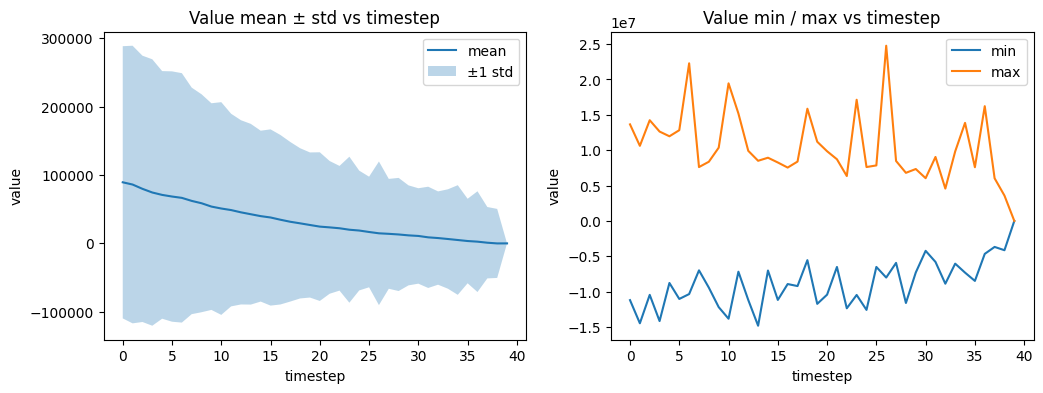

In [38]:
def plot_value_distributions(debug_data):
    stats = []

    for t, d in debug_data.items():
        v = d["values"]
        stats.append({
            "timestep": t,
            "mean": v.mean(),
            "std": v.std(),
            "min": v.min(),
            "max": v.max(),
        })

    df = pd.DataFrame(stats)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(df["timestep"], df["mean"], label="mean")
    ax[0].fill_between(
        df["timestep"],
        df["mean"] - df["std"],
        df["mean"] + df["std"],
        alpha=0.3,
        label="±1 std",
    )
    ax[0].set_title("Value mean ± std vs timestep")
    ax[0].set_xlabel("timestep")
    ax[0].set_ylabel("value")
    ax[0].legend()

    ax[1].plot(df["timestep"], df["min"], label="min")
    ax[1].plot(df["timestep"], df["max"], label="max")
    ax[1].set_title("Value min / max vs timestep")
    ax[1].set_xlabel("timestep")
    ax[1].set_ylabel("value")
    ax[1].legend()

    plt.show()

plot_value_distributions(debug_data)

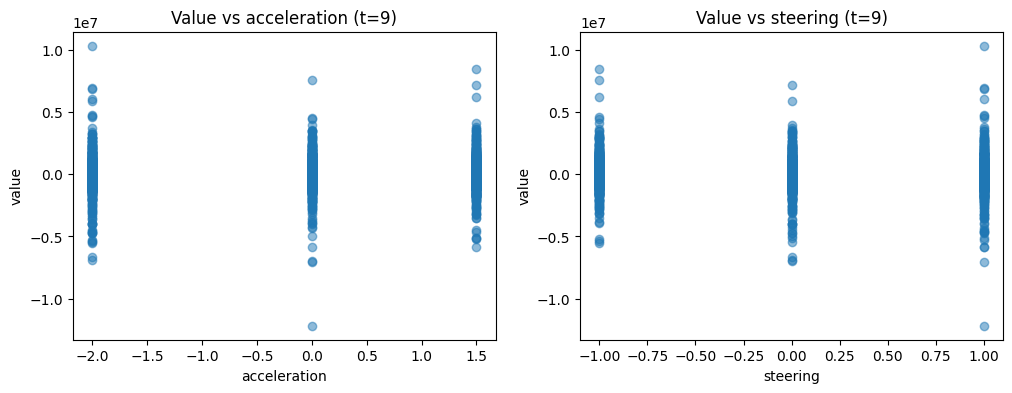

In [39]:
def plot_value_vs_action(debug_data, timestep, action_set):
    d = debug_data[timestep]
    action_idx = d["actions"].astype(int)
    values     = d["values"]

    actions = action_set[action_idx]
    accel   = actions[:, 0]
    steer   = actions[:, 1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].scatter(accel, values, alpha=0.5)
    ax[0].set_xlabel("acceleration")
    ax[0].set_ylabel("value")
    ax[0].set_title(f"Value vs acceleration (t={timestep})")

    ax[1].scatter(steer, values, alpha=0.5)
    ax[1].set_xlabel("steering")
    ax[1].set_ylabel("value")
    ax[1].set_title(f"Value vs steering (t={timestep})")

    plt.show()

plot_value_vs_action(debug_data, timestep=9, action_set=defender_action_set)



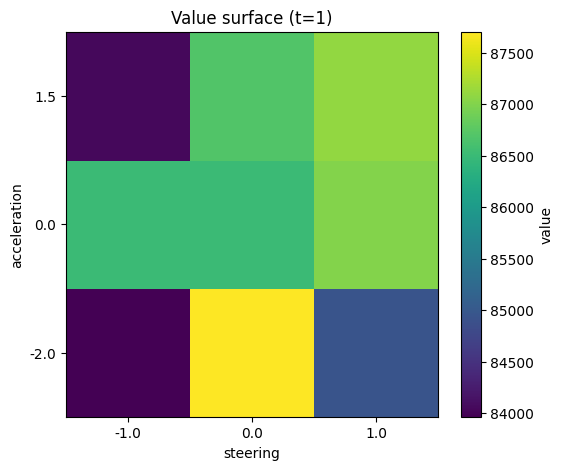

In [40]:
def plot_action_value_surface(debug_data, timestep, action_set):
    d = debug_data[timestep]
    accel, steer = unpack_actions(d["actions"], action_set)

    df = pd.DataFrame({
        "accel": accel,
        "steer": steer,
        "value": d["values"],
    })

    pivot = df.pivot_table(
        index="accel",
        columns="steer",
        values="value",
        aggfunc="mean",
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(pivot.values, origin="lower", aspect="auto")
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xlabel("steering")
    plt.ylabel("acceleration")
    plt.title(f"Value surface (t={timestep})")
    plt.colorbar(label="value")
    plt.show()

plot_action_value_surface(debug_data, 1, defender_action_set)


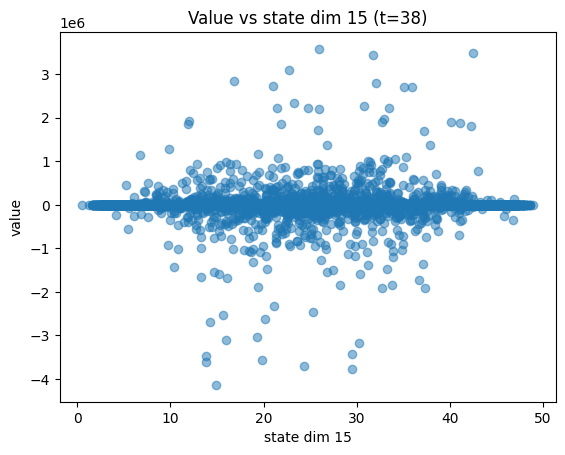

In [50]:
def plot_value_vs_state_dim(debug_data, timestep, dim, label=None):
    d = debug_data[timestep]
    x = d["particles"][:, dim]
    v = d["values"]

    plt.scatter(x, v, alpha=0.5)
    plt.xlabel(label or f"state dim {dim}")
    plt.ylabel("value")
    plt.title(f"Value vs state dim {dim} (t={timestep})")
    plt.show()

plot_value_vs_state_dim(debug_data, 38, 15)

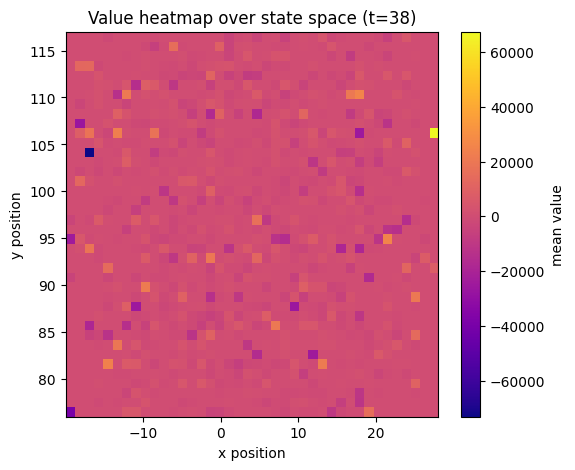

In [46]:
def plot_value_vs_state_2d_heatmap(
    debug_data,
    timestep,
    dim_x,
    dim_y,
    bins=30,
    label_x=None,
    label_y=None,
    cmap="plasma",
):
    d = debug_data[timestep]

    x = d["particles"][:, dim_x]
    y = d["particles"][:, dim_y]
    v = d["values"]

    # 2D binning
    heatmap, xedges, yedges = np.histogram2d(
        x, y, bins=bins, weights=v
    )
    counts, _, _ = np.histogram2d(x, y, bins=bins)

    # Avoid division by zero
    heatmap = np.divide(
        heatmap,
        counts,
        out=np.zeros_like(heatmap),
        where=counts > 0,
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(
        heatmap.T,
        origin="lower",
        aspect="auto",
        extent=[
            xedges[0], xedges[-1],
            yedges[0], yedges[-1],
        ],
        cmap=cmap,
    )
    plt.colorbar(label="mean value")

    plt.xlabel(label_x or f"state dim {dim_x}")
    plt.ylabel(label_y or f"state dim {dim_y}")
    plt.title(f"Value heatmap over state space (t={timestep})")
    plt.show()

plot_value_vs_state_2d_heatmap(
    debug_data,
    timestep=38,
    dim_x=12,
    dim_y=13,
    label_x="x position",
    label_y="y position",
    bins=40,
)


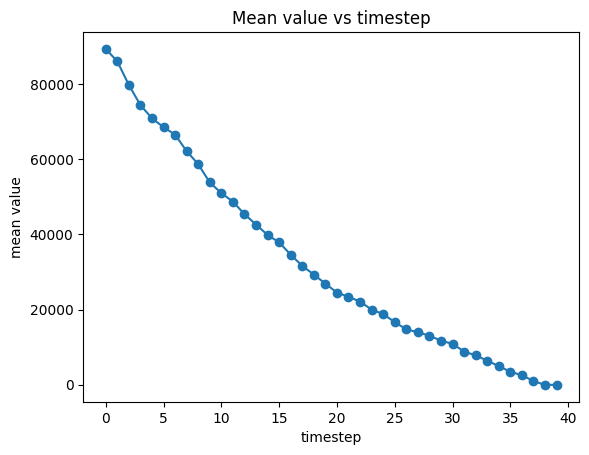

In [43]:
def plot_mean_value_vs_timestep(debug_data):
    ts = []
    means = []

    for t, d in debug_data.items():
        ts.append(t)
        means.append(d["values"].mean())

    plt.plot(ts, means, marker="o")
    plt.xlabel("timestep")
    plt.ylabel("mean value")
    plt.title("Mean value vs timestep")
    plt.show()

plot_mean_value_vs_timestep(debug_data)

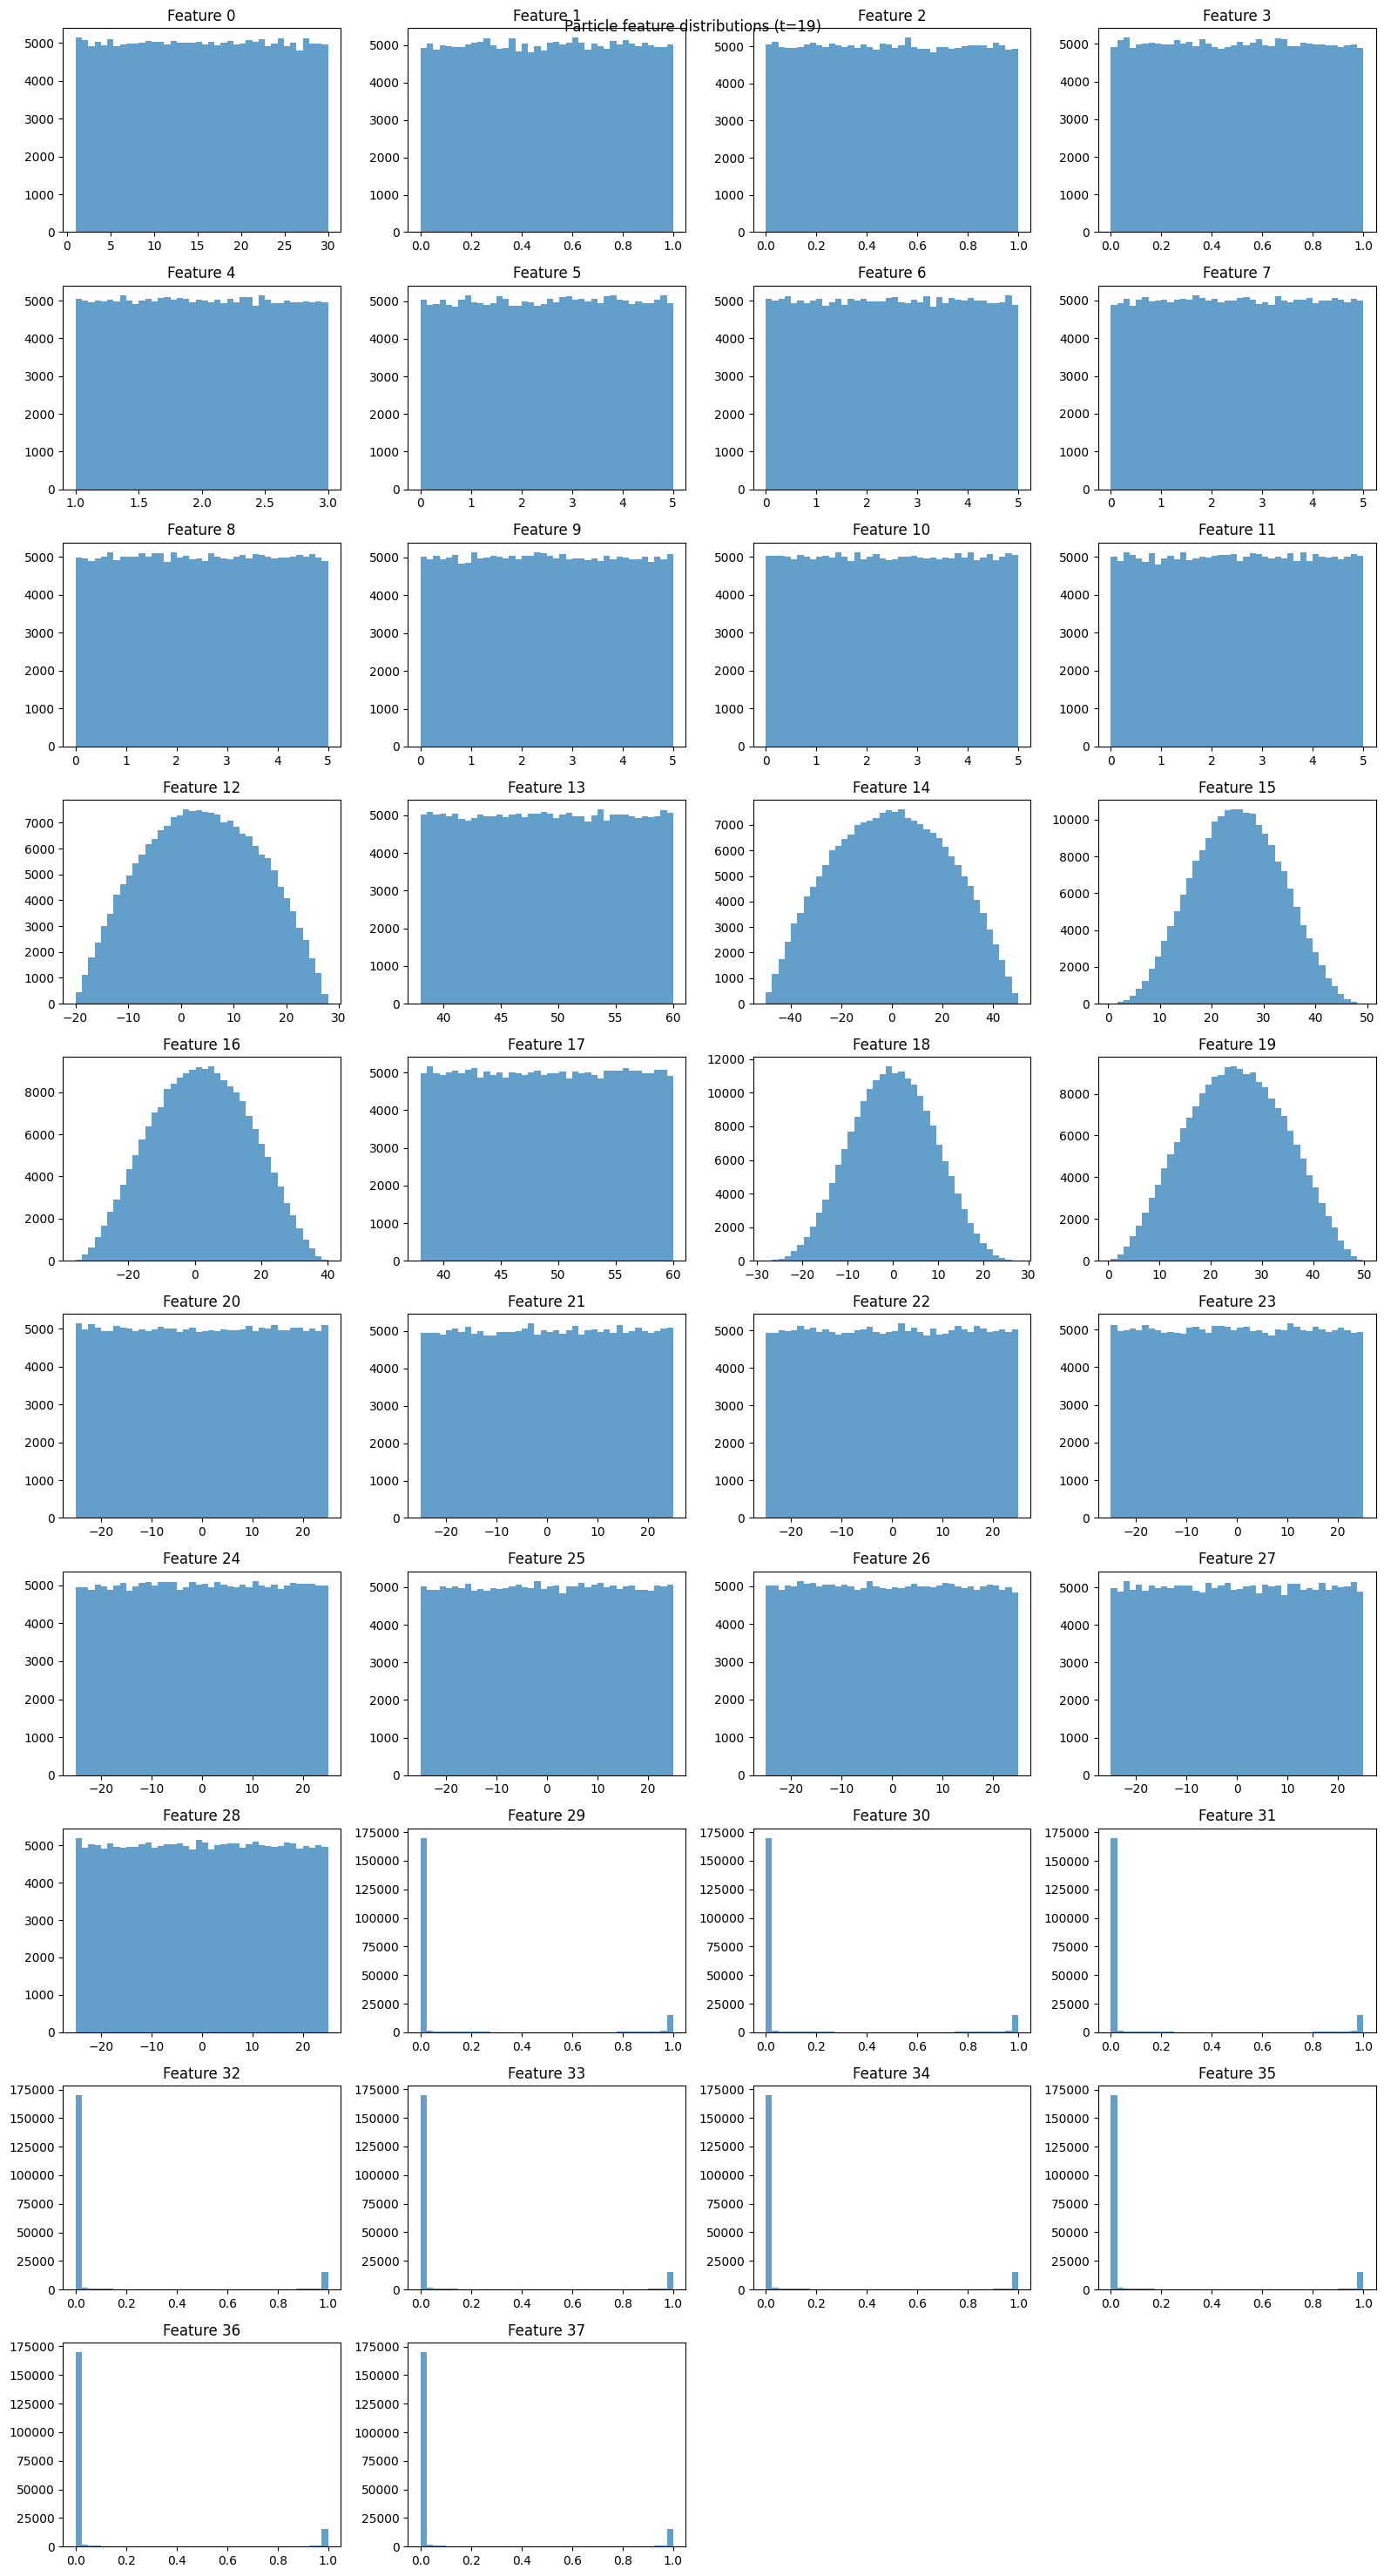

In [44]:
def plot_particle_distributions(
    debug_data,
    timestep,
    feature_names=None,
    bins=40,
):
    """
    Plot histograms of each particle feature at a given timestep.

    debug_data: dict[timestep] -> {particles, actions, values}
    timestep: int
    feature_names: optional list of names for particle dimensions
    """
    particles = debug_data[timestep]["particles"]
    num_features = particles.shape[1]

    ncols = 4
    nrows = math.ceil(num_features / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4 * ncols, 3 * nrows),
        squeeze=False,
    )

    for i in range(num_features):
        ax = axes[i // ncols, i % ncols]
        ax.hist(particles[:, i], bins=bins, alpha=0.7)
        ax.set_title(
            feature_names[i] if feature_names else f"Feature {i}"
        )

    # Hide unused subplots
    for j in range(num_features, nrows * ncols):
        axes[j // ncols, j % ncols].axis("off")

    plt.suptitle(f"Particle feature distributions (t={timestep})")
    plt.tight_layout()
    plt.show()

plot_particle_distributions(debug_data, timestep=19)
